In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Config
input_length = 3001
latent_dim = 64
batch_size = 64
epochs = 30

# Path split
splits_root = r"E:\Skripsi\DEC\dataset\ae-supervised-dataset\splits"
train_manifest = os.path.join(splits_root, "train.csv")
test_manifest  = os.path.join(splits_root, "test.csv")


In [37]:
def load_waveform(path):
    st = read(path)
    tr = st[0].data.astype(np.float32)
    return tr

def load_dataset(manifest_csv):
    df = pd.read_csv(manifest_csv)
    X = [load_waveform(p) for p in df["path"]]
    X = np.array(X)
    X = np.expand_dims(X, -1)   # shape (N, 3001, 1)
    return X, df["label"].values


In [38]:
X_train, y_train = load_dataset(train_manifest)
X_test, y_test   = load_dataset(test_manifest)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (3861, 3001, 1)
Test shape : (966, 3001, 1)


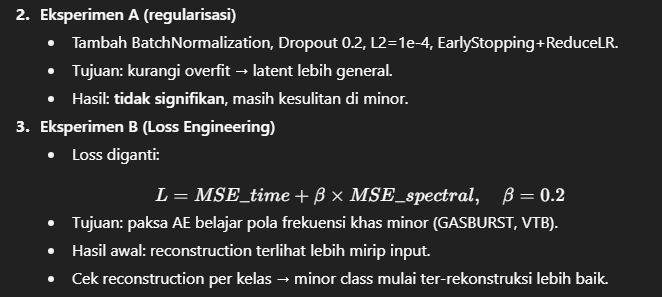

In [39]:
def build_autoencoder(input_length, latent_dim):
    inp = keras.Input(shape=(input_length,1))

    # === Encoder ===
    x = layers.Conv1D(16, 7, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)   # Tambahkan BN
    x = layers.MaxPooling1D(2)(x)        # ~1500

    x = layers.Conv1D(32, 7, padding="same", activation="relu",
                      kernel_regularizer=keras.regularizers.l2(1e-4))(x)  # L2 lebih besar
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)        # ~750
    x = layers.Dropout(0.2)(x)           # Dropout lebih besar

    x = layers.Conv1D(64, 7, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)        # ~375

    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name="latent")(x)

    # === Decoder ===
    x = layers.Dense((input_length//8)*64)(latent)
    x = layers.Reshape((input_length//8, 64))(x)

    x = layers.Conv1DTranspose(32, 7, strides=2, padding="same", activation="relu")(x) # ~750
    x = layers.Conv1DTranspose(16, 7, strides=2, padding="same", activation="relu")(x) # ~1500
    x = layers.Conv1DTranspose(1, 7, strides=2, padding="same")(x)                     # ~3000

    x = layers.ZeroPadding1D(padding=(0,1))(x)   # dari 3000 → 3001

    model = keras.Model(inp, x, name="CAE")
    encoder = keras.Model(inp, latent, name="Encoder")
    return model, encoder


In [40]:

def spectral_loss(y_true, y_pred):
    # Hapus dim channel (N, 3001, 1) -> (N, 3001)
    y_true = tf.squeeze(y_true, -1)
    y_pred = tf.squeeze(y_pred, -1)
    
    # Short-Time Fourier Transform
    stft_true = tf.abs(tf.signal.stft(y_true, frame_length=256, frame_step=64))
    stft_pred = tf.abs(tf.signal.stft(y_pred, frame_length=256, frame_step=64))
    
    # MSE pada magnitude spektrum
    return tf.reduce_mean(tf.square(stft_true - stft_pred))

def combined_loss(y_true, y_pred):
    # Time-domain MSE
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    # Spectral MSE
    spec = spectral_loss(y_true, y_pred)
    # Gabungan
    return mse + 0.2 * spec   # β = 0.2 (bisa coba 0.1, 0.5)


In [41]:
model, encoder = build_autoencoder(input_length, latent_dim)
latent_dim = encoder.output_shape[1]
print(f"Encoder loaded. Latent dim = {latent_dim}")


Encoder loaded. Latent dim = 64


In [42]:
model.summary()

encoder.summary()

Model: "CAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3001, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 3001, 16)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3001, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1500, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1500, 32)       │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1500, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 750, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 750, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 750, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 750, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 375, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 24000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 64)             │     1,536,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24000)          │     1,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 375, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_6              │ (None, 750, 32)        │        14,368 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_7              │ (None, 1500, 16)       │         3,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_8              │ (None, 3000, 1)        │           113 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d_2                │ (None, 3001, 1)        │             0 │
│ (ZeroPadding1D)                 │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,132,737 (11.95 MB)

 Trainable params: 3,132,513 (11.95 MB)

 Non-trainable params: 224 (896.00 B)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3001, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 3001, 16)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3001, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1500, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1500, 32)       │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1500, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 750, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 750, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 750, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 750, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 375, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 24000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 64)             │     1,536,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,554,656 (5.93 MB)

 Trainable params: 1,554,432 (5.93 MB)

 Non-trainable params: 224 (896.00 B)

In [43]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=combined_loss)

callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
  tf.keras.callbacks.ModelCheckpoint("best_ae.h5", monitor="val_loss", save_best_only=True),
  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
]

history = model.fit(
    X_train, X_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1
)


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - loss: 8.6766 - val_loss: 19.2806
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - loss: 6.7333 - val_loss: 18.5339
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - loss: 6.4000 - val_loss: 17.9986
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - loss: 6.2678 - val_loss: 15.4841
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - loss: 6.0268 - val_loss: 12.4089
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - loss: 5.8849 - val_loss: 10.1134
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - loss: 5.7534 - val_loss: 8.6217
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - loss: 5.6342 - val_loss: 7.3001
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - loss: 5.5555 - val_loss: 6.6409
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - loss: 5.4597 - val_loss: 6.4806
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 268ms/step - loss: 5.3358 - val_loss: 6.3303
Epoch 12/30
55/55 ━━━━━━━━━━━━━━━━━

In [47]:
# Simpan hanya encoder
encoder = keras.Model(model.input, model.get_layer("latent").output)
encoder.save("encoder.h5")

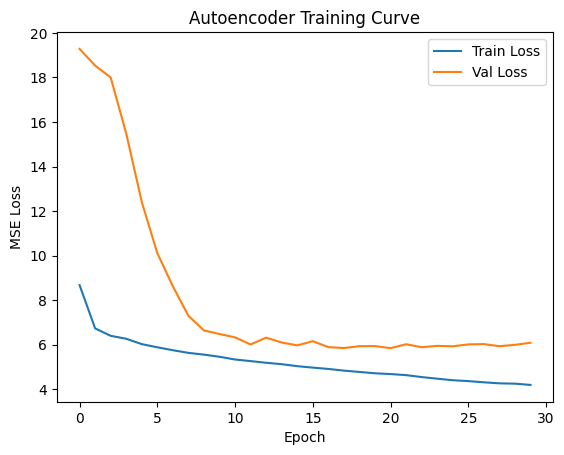

In [45]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Autoencoder Training Curve")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


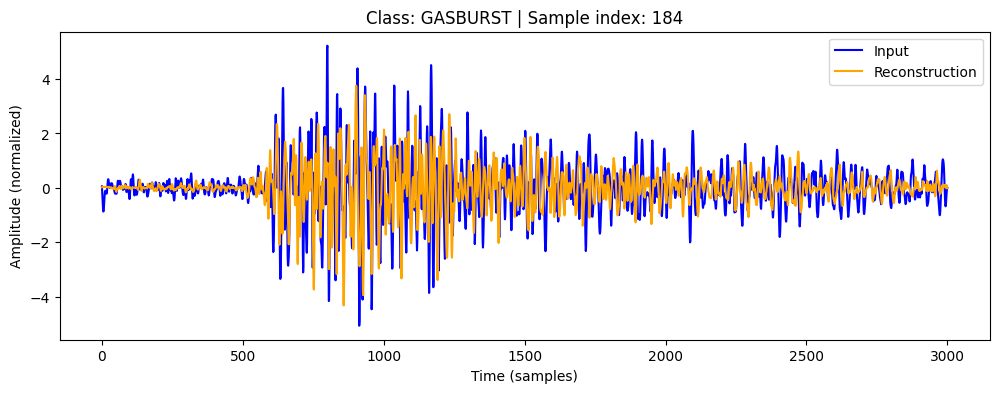

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


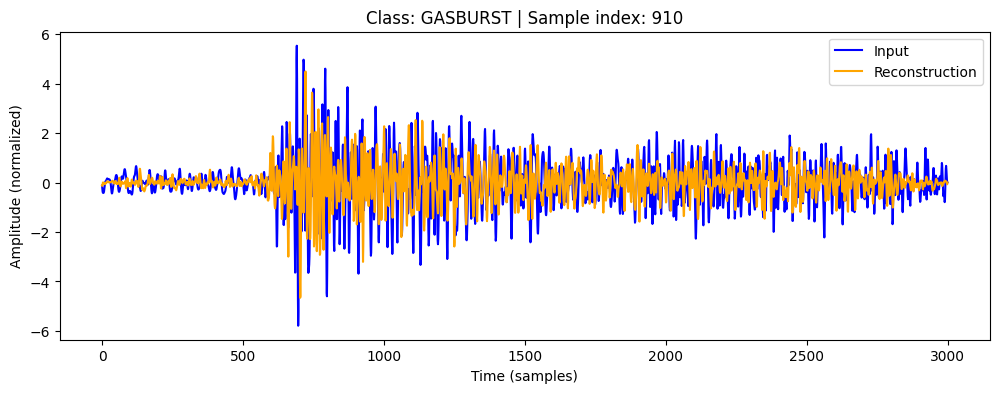

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


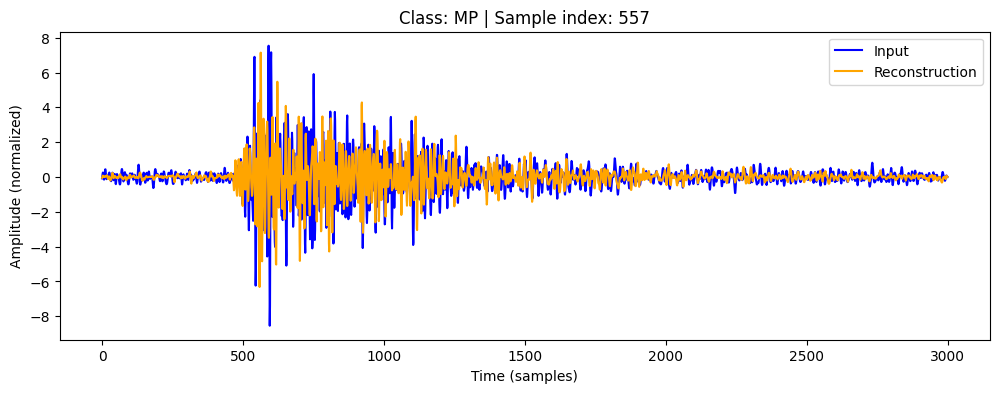

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


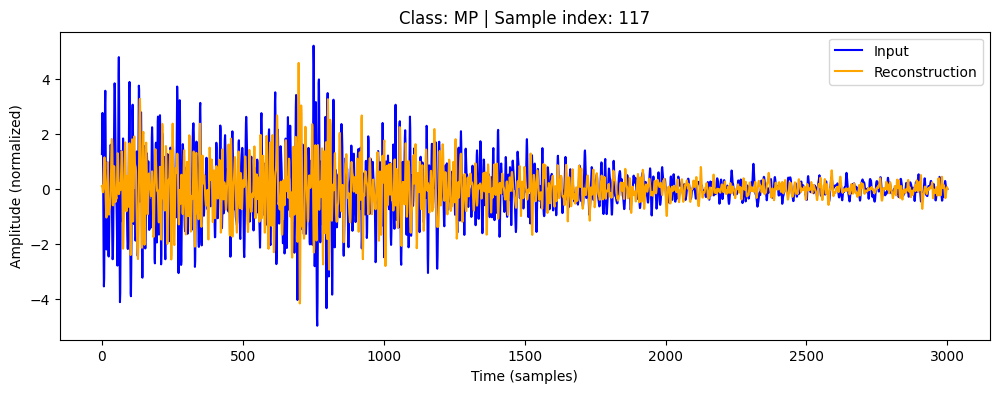

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


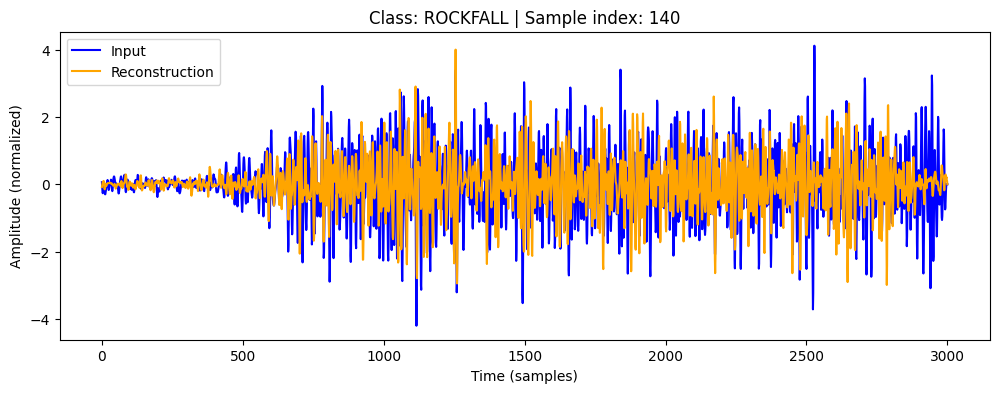

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


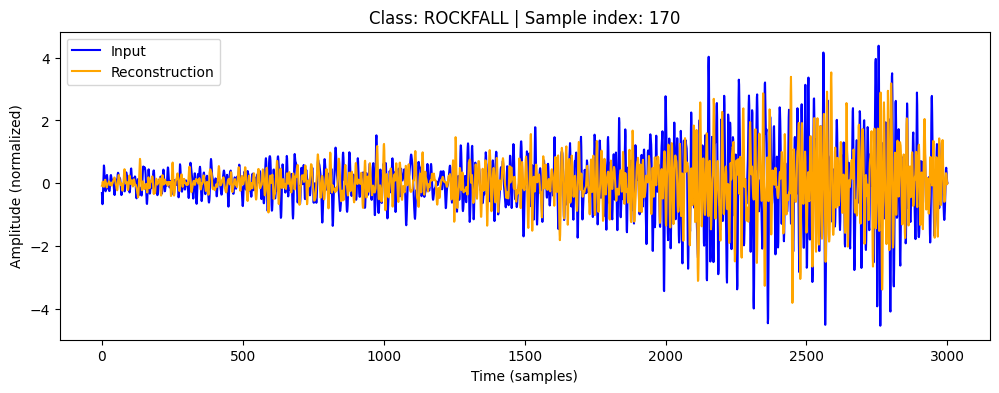

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


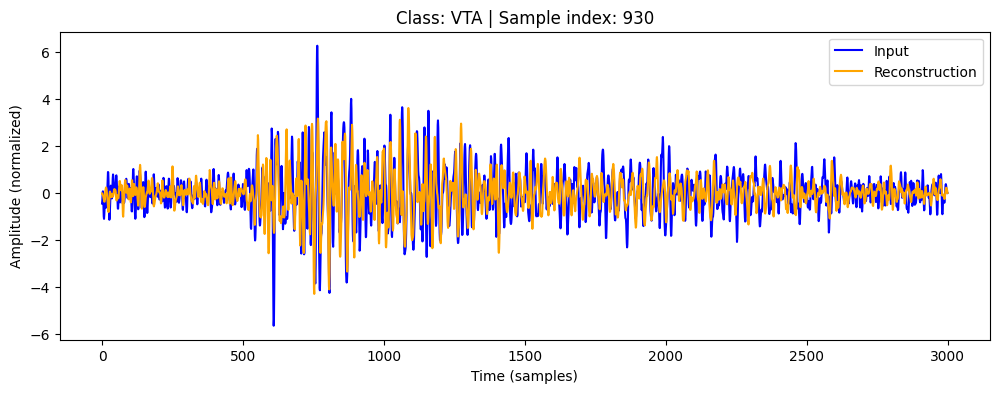

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


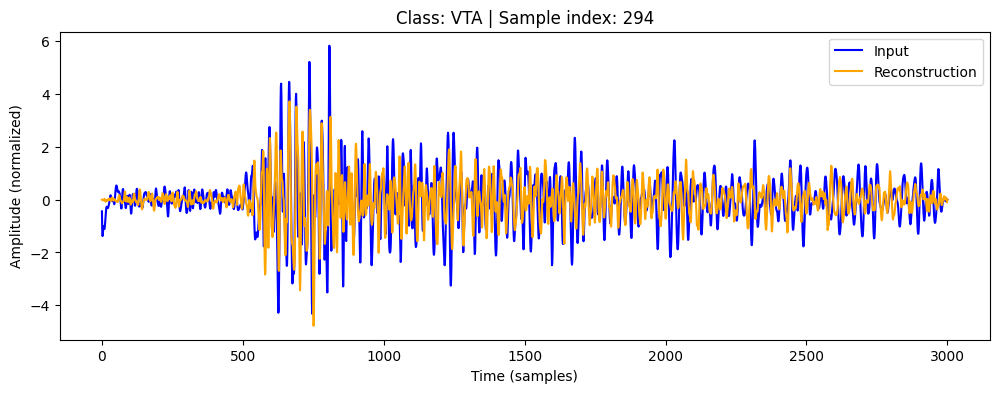

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


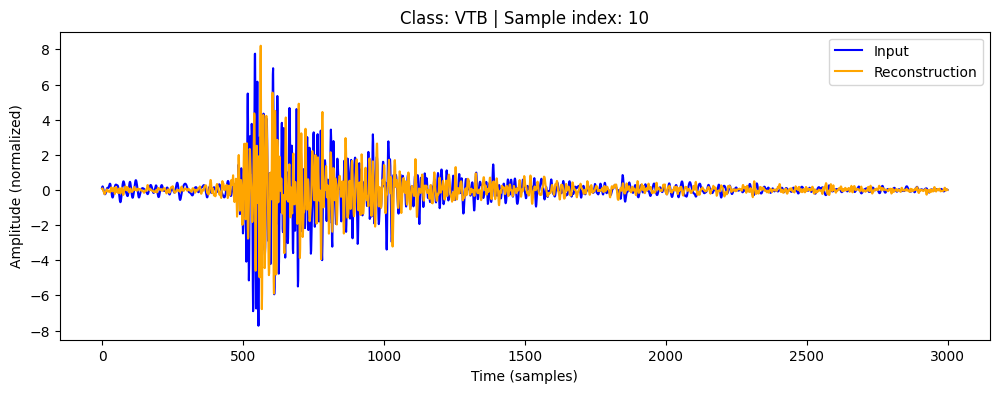

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


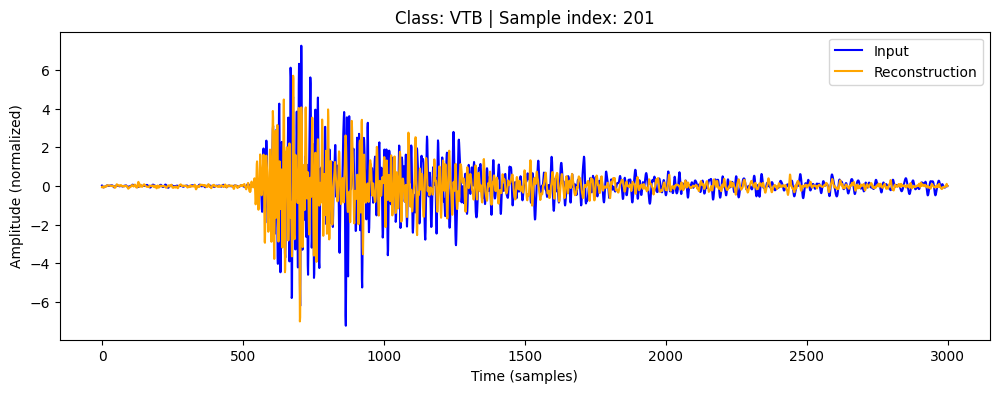

In [46]:
def plot_reconstruction_examples(model, X, y, n_classes=5, n_samples=1):
    labels = np.unique(y)
    for label in labels[:n_classes]:
        idxs = np.where(y == label)[0]
        for _ in range(n_samples):
            sample_idx = random.choice(idxs)
            x_in = X[sample_idx:sample_idx+1]
            x_out = model.predict(x_in)

            plt.figure(figsize=(12,4))
            plt.plot(x_in.flatten(), label="Input", color="blue")
            plt.plot(x_out.flatten(), label="Reconstruction", color="orange")
            plt.title(f"Class: {label} | Sample index: {sample_idx}")
            plt.xlabel("Time (samples)")
            plt.ylabel("Amplitude (normalized)")
            plt.legend()
            plt.show()

# === Cara pakai ===
plot_reconstruction_examples(model, X_test, y_test, n_classes=5, n_samples=2)